### Importing library 

In [20]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
tf.__version__

'2.5.0'

In [3]:
# allowing memory growth
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

###  Setup Paths

In [4]:
WORKSPACE_PATH = 'C:/Users/chhip/Desktop/Tensorflow/workspace/ParallelDots'
SCRIPTS_PATH = 'C:/Users/chhip/Desktop/Tensorflow/scripts/preprocessing'
APIMODEL_PATH = 'C:/Users/chhip/Desktop/Tensorflow/models'
ANNOTATION_PATH = WORKSPACE_PATH+'/annotations'
IMAGE_PATH = WORKSPACE_PATH+'/images'
MODEL_PATH = WORKSPACE_PATH+'/models'
PRETRAINED_MODEL_PATH = WORKSPACE_PATH+'/pre-trained-models'
CONFIG_PATH = MODEL_PATH+'/my_ssd_mobnet/pipeline.config'
CHECKPOINT_PATH = MODEL_PATH+'/my_ssd_mobnet/'

### Creating label Map

In [21]:
df = pd.read_csv(r'C:\Users\chhip\Desktop\Tensorflow\workspace\ParallelDots\db1_image_annotation.csv')
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,db1.jpg,2272,1704,object,1105,919,1315,1127
1,db1.jpg,2272,1704,object,1005,1271,1166,1363
2,db1.jpg,2272,1704,object,600,1365,745,1494
3,db1.jpg,2272,1704,object,945,1370,1123,1508
4,db1.jpg,2272,1704,object,1536,1432,1898,1522


In [22]:
labels =['object']
label = []
for i in range(1, len(labels)+1):
    label.append({'name':labels[i-1], 'id':i})
label

[{'name': 'object', 'id': 1}]

In [23]:
# write pbtxt file
with open(ANNOTATION_PATH + '\label_map.pbtxt', 'w') as f:
    for i in label:
        f.write('item { \n')
        f.write('\tid:{}\n'.format(i['id']))
        f.write('\tname:\'{}\'\n'.format(i['name']))
        f.write('}\n')

{'name': 'object', 'id': 1}


### Generating tf.record

In [6]:
!python {SCRIPTS_PATH + '/generate_tfrecord.py'} -x {IMAGE_PATH + '/train'} -l {ANNOTATION_PATH + '/label_map.pbtxt'} -o {ANNOTATION_PATH + '/train.record'}
!python {SCRIPTS_PATH + '/generate_tfrecord.py'} -x{IMAGE_PATH + '/test'} -l {ANNOTATION_PATH + '/label_map.pbtxt'} -o {ANNOTATION_PATH + '/test.record'}


Successfully created the TFRecord file: C:/Users/chhip/Desktop/Tensorflow/workspace/ParallelDots/annotations/train.record
Successfully created the TFRecord file: C:/Users/chhip/Desktop/Tensorflow/workspace/ParallelDots/annotations/test.record


### Copy model config to training Folder

In [5]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet'

In [ ]:
#copy pipeline config from pretrained model to our custom model
!mkdir {'Tensorflow\workspace\models\\'+CUSTOM_MODEL_NAME}
!cp {PRETRAINED_MODEL_PATH+'/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config'} {MODEL_PATH+'/'+CUSTOM_MODEL_NAME}

### Update Config For Transfer Learning

In [6]:
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [7]:
CONFIG_PATH = MODEL_PATH+'/'+CUSTOM_MODEL_NAME+'/pipeline.config'

In [8]:
config = config_util.get_configs_from_pipeline_file(CONFIG_PATH)
config

{'model': ssd {
   num_classes: 1
   image_resizer {
     fixed_shape_resizer {
       height: 320
       width: 320
     }
   }
   feature_extractor {
     type: "ssd_mobilenet_v2_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 3.9999998989515007e-05
         }
       }
       initializer {
         random_normal_initializer {
           mean: 0.0
           stddev: 0.009999999776482582
         }
       }
       activation: RELU_6
       batch_norm {
         decay: 0.996999979019165
         scale: true
         epsilon: 0.0010000000474974513
       }
     }
     use_depthwise: true
     override_base_feature_extractor_hyperparams: true
     fpn {
       min_level: 3
       max_level: 7
       additional_layer_depth: 128
     }
   }
   box_coder {
     faster_rcnn_box_coder {
       y_scale: 10.0
       x_scale: 10.0
       height_scale: 5.0
       width_scale: 5.0
     }
   }
   match

In [9]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(CONFIG_PATH, "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)

In [10]:
pipeline_config.model.ssd.num_classes = 1
pipeline_config.train_config.batch_size = 16
pipeline_config.train_config.fine_tune_checkpoint = PRETRAINED_MODEL_PATH+'/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0'
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= ANNOTATION_PATH + '/label_map.pbtxt'
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [ANNOTATION_PATH + '/train.record']
pipeline_config.eval_input_reader[0].label_map_path = ANNOTATION_PATH + '/label_map.pbtxt'
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [ANNOTATION_PATH + '/test.record']

In [11]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(CONFIG_PATH, "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)

### Model Training

In [12]:
#run the following command in python shell
print("""python {}/research/object_detection/model_main_tf2.py --model_dir={}/{} --pipeline_config_path={}/{}/pipeline.config --num_train_steps=5000""".format(APIMODEL_PATH, MODEL_PATH,CUSTOM_MODEL_NAME,MODEL_PATH,CUSTOM_MODEL_NAME))

python C:/Users/chhip/Desktop/Tensorflow/models/research/object_detection/model_main_tf2.py --model_dir=C:/Users/chhip/Desktop/Tensorflow/workspace/ParallelDots/models/my_ssd_mobnet --pipeline_config_path=C:/Users/chhip/Desktop/Tensorflow/workspace/ParallelDots/models/my_ssd_mobnet/pipeline.config --num_train_steps=5000


### Loading Train Model From Checkpoint

In [13]:
import os
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

In [14]:

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(CONFIG_PATH)
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(CHECKPOINT_PATH, 'ckpt-7')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

In [15]:
import cv2 
import numpy as np

In [16]:
category_index = label_map_util.create_category_index_from_labelmap(ANNOTATION_PATH+'/label_map.pbtxt')
category_index

{1: {'id': 1, 'name': 'object'}}

In [23]:
def show_prediction(image_path):
    image = cv2.imread(image_path)
    image_np = np.array(image)
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)

    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()
    # draw bounding boxes
    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                line_thickness=2,
                max_boxes_to_draw=50,
                min_score_thresh=.5,
                agnostic_mode=False)

    plt.imshow(image_np_with_detections)
    plt.show()

In [44]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,8)

In [69]:
test_img_path = IMAGE_PATH+'/test/'
test_img_path

'C:/Users/chhip/Desktop/Tensorflow/workspace/ParallelDots/images/test/'

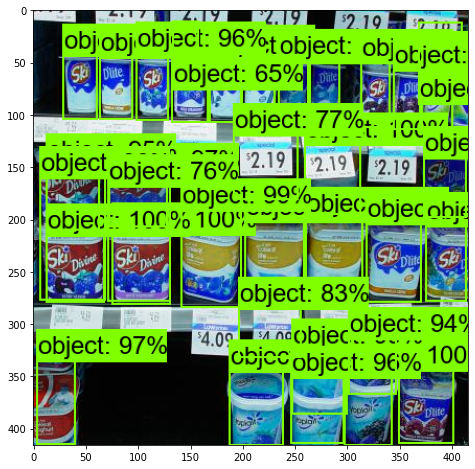

In [70]:
show_prediction(r'{}db173_jpg.rf.cac7b156556d05a2ad6722ae71a0088c.jpg'.format(test_img_path))

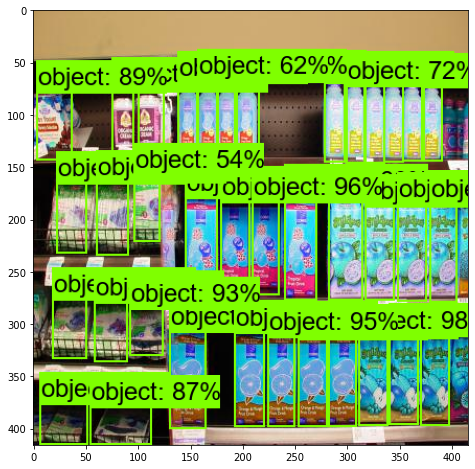

In [71]:
show_prediction(r'{}db53_jpg.rf.1c77201b5dbc5261c3ea596f4b5de401.jpg'.format(test_img_path))

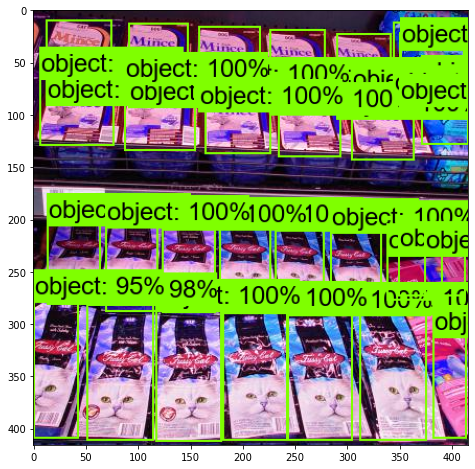

In [72]:
show_prediction(r'{}db268_jpg.rf.6ed3fe505400bc09cf8ea8be614db78d.jpg'.format(test_img_path))